# Predictive Analysis of Heart Disease Dataset

## Introduction

In the United States, heart disease is the leading cause of death in both men and women. Coronary heart disease occurs when the arteries struggle to supply oxygen and nutrient-rich blood to the heart. The most common cause is the buildup of fatty, cholesterol-containing plaques along the arteries, narrowing blood passage to the heart. Angina is a type of chest pain which is a common symptom in patients with heart disease. When blood flow to the heart is severely reduced or completely blocked when plaques dislodge and flow into smaller coronary arteries, it results in a heart attack. Therefore, early detection of heart disease is extremely important for patients.

For this project, I am investigating whether a patient will be diagnosed with heart disease. More precisely, can chest pain type, max heart rate, and exercise-induced angina accurately predict the presence of heart disease in patients?

To answer this question, a heart disease dataset from the Cleveland database will be analyzed. The database originally contains 76 attributes but the dataset contains 14 attributes. The dataset consists of both integer and categorical variables. The target variable is the diagnosis of heart disease which has a range of 0-5. A value of 0 indicates no heart disease and values between 1-4 indicate the presence of heart disease.

## Methods

To answer this question, I will be creating a model using the K-Nearest Neighbors algorithm that can classify data into two categories, No Heart Disease vs. Has Heart Disease. The main predictors are chest pain type, max heart rate, and exercise-induced angina. The effects of age and sex on the classification will also be investigated. The data will be split into training and testing datasets, and standardized separately to ensure that the testing data does not influence model training. Using the training data, cross-validation will be used to fit and train the model to minimize overfitting. We can optimize the model by changing the number of cross-validation folds and k-nearest neighbours, then use it to make predictions on the testing data. Classification model statistics such as accuracy, precision, and recall will be used to assess how well the model performs.

One way to visualize the results would be a table that lists the accuracy, precision, and recall of the test data predictions. Additionally, this information can be visualized by plotting each data point and mapping the border between positive or negative predictions based on our model.

In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [45]:
url <- "https://raw.githubusercontent.com/deenahl/dsci-100-2024s-project/main/data/heart_disease/processed.cleveland.data"
data <- read_delim(url, delim=",", col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"))
# categorical_variables <- c("sex", "cp", "exang", "target")
# integer_variables <- c("age", "thalach")

heart_disease_ds <- data |>
    select(age, sex, cp, exang, thalach, target) |>
    mutate(
        target = as_factor(target),
        target = fct_recode(target, "No Heart Disease"="0", "Has Heart Disease"="1", "Has Heart Disease"="2", "Has Heart Disease"="3", "Has Heart Disease"="4"))
    # mutate(across(all_of(categorical_variables), as_factor)) |>
    # mutate(across(all_of(integer_variables), as.integer)) |>
    # mutate(sex = fct_recode(sex, "Male"="1", "Female"="0")) |>
    # mutate(cp = fct_recode(cp, "Typical angina"="1", "Atypical angina"="2", "Non-anginal pain"="3", "Asymptomatic"="4")) |>
    # mutate(exang = fct_recode(exang, "True"="1", "False"="0")) |>
    # mutate(target = fct_recode(target, "No Heart Disease"="0", "Has Heart Disease"="1", "Has Heart Disease"="2", "Has Heart Disease"="3", "Has Heart Disease"="4"))

# heart_disease_ds

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,exang,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,0,150,No Heart Disease
67,1,4,1,108,Has Heart Disease
67,1,4,1,129,Has Heart Disease
37,1,3,0,187,No Heart Disease
41,0,2,0,172,No Heart Disease
56,1,2,0,178,No Heart Disease
62,0,4,0,160,Has Heart Disease
57,0,4,1,163,No Heart Disease
63,1,4,0,147,Has Heart Disease


In [165]:
set.seed(1207)

hd_split <- initial_split(heart_disease_ds, prop = 0.8, strata = target)
hd_train <- training(hd_split) |>
            select(age, sex, cp, exang, thalach, target) 

# hd_train

target_table <- hd_train |>
                group_by(target) |>
                summarize(count = n())
                # mutate(target = fct_recode(target, "No Heart Disease"="0", "Has Heart Disease"="1"))

missing_data <- hd_train |>
                rowwise() |>
                mutate(missing = any(is.na(c(age, sex, cp, exang, thalach, target)))) |>
                filter(missing == TRUE)

predictor_stats <- hd_train |>
                    summarize(mean_age = mean(age), 
                              mean_thalach = mean(thalach))

# summary_tables    
target_table
missing_data
predictor_stats

target,count
<fct>,<int>
No Heart Disease,131
Has Heart Disease,111


age,sex,cp,exang,thalach,target,missing
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>


mean_age,mean_thalach
<dbl>,<dbl>
54.46281,150.2603


In [ ]:
plot_1 <- hd_train |>
        mutate(
            cp = as_factor(cp),
            cp = fct_recode(cp, "Typical angina"="1", "Atypical angina"="2", "Non-anginal pain"="3", "Asymptomatic"="4")) |>
        group_by(cp, target) |>
        ggplot(aes(x = target, fill = cp)) +
        geom_histogram(stat = "count") +
        labs(x="Diagnosis of Heart Disease", fill="Chest Pain Type") +
        ggtitle("Chest Pain Type vs. Diagnosis of Heart Disease")
plot_1

In [ ]:
plot_2 <- hd_train |>
        ggplot(aes(x = thalach, fill = target)) +
        geom_histogram(alpha = 0.5, position="identity", bins = 30, binwidth = 5) +
        facet_grid(rows = vars(target)) +
        labs(x="Max Heart Rate", fill="Diagnosis of Heart Disease") +
        ggtitle("Max Heart Rate vs. Diagnosis of Heart Disease")
plot_2

In [ ]:
plot_3 <- hd_train |>
        mutate(
            exang = as_factor(exang),
            exang = fct_recode(exang, "True"="1", "False"="0")) |>
        ggplot(aes(x = target, fill = exang)) +
        geom_histogram(stat = "count") +
        labs(x="Diagnosis of Heart Disease", fill="Exercise Induced Angina") +
        ggtitle("Exercise Induced Angina vs. Diagnosis of Heart Disease")
plot_3

### Hyperparameter Optimization

In [166]:
# hd_train
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe <- recipe(target ~ age + sex + cp + exang + thalach, data = hd_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

hd_fold <- vfold_cv(hd_train, v = 8, strata = target)

In [167]:
knn_tune_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune_spec) |>
    tune_grid(resamples = hd_fold, 
              grid = k_vals,
              control = control_resamples(save_pred = TRUE)) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
knn_tune_results

neighbors,mean
<dbl>,<dbl>
1,0.7072024
3,0.7480719
5,0.7522386
7,0.7441741
9,0.7687523
11,0.7517983
13,0.7599972
15,0.7684650
17,0.7724972


In [169]:
knn_tune_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune_spec) |>
    tune_grid(resamples = hd_fold, 
              grid = k_vals,
              control = control_resamples(save_pred = TRUE))

In [170]:
knn_tune_accuracy <- knn_tune_results |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

knn_tune_accuracy

neighbors,mean
<dbl>,<dbl>
1,0.7072024
3,0.7480719
5,0.7522386
7,0.7441741
9,0.7687523
11,0.7517983
13,0.7599972
15,0.7684650
17,0.7724972


In [175]:
knn_tune_recall <- knn_tune_results |>
    collect_predictions() |>
    group_by(neighbors, id) |>
    recall(truth = target, .pred_class, event_level="second") |>
    group_by(neighbors) |>
    summarize(
        recall = mean(.estimate)) |>
    select(recall)

knn_tune_accuracy <- knn_tune_accuracy |>
    bind_cols(knn_tune_recall)

knn_tune_accuracy

neighbors,mean,recall
<dbl>,<dbl>,<dbl>
1,0.7072024,0.6304945
3,0.7480719,0.6861264
5,0.7522386,0.7486264
7,0.7441741,0.7307692
9,0.7687523,0.7383242
11,0.7517983,0.7108516
13,0.7599972,0.7019231
15,0.7684650,0.7019231
17,0.7724972,0.7019231


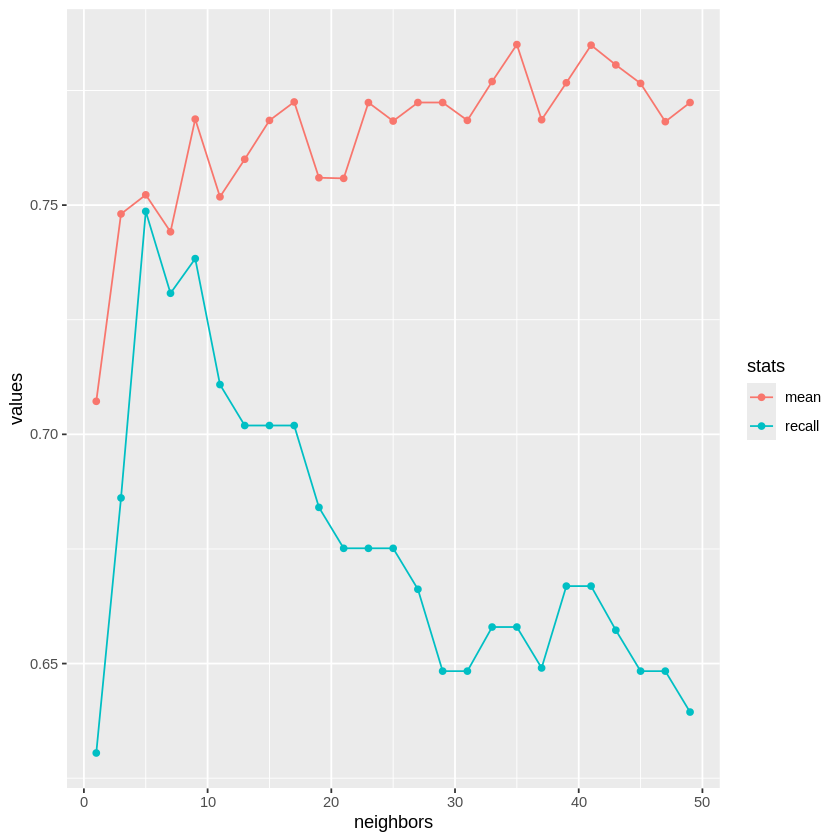

In [178]:
knn_tune_plot <- knn_tune_accuracy |>
    pivot_longer(cols = mean:recall, names_to = "stats", values_to = "values") |>
    ggplot(aes(x = neighbors, y = values, color = stats)) +
    geom_point() +
    geom_line()

knn_tune_plot

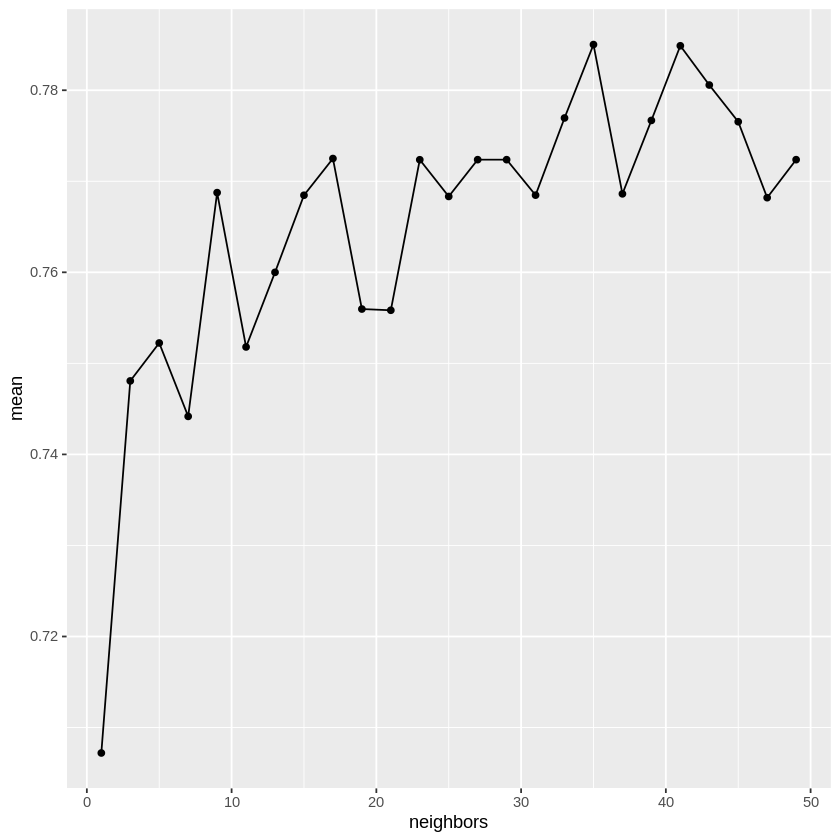

In [172]:
knn_tune_plot <- knn_tune_accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()
knn_tune_plot

In [173]:
best_k <- knn_tune_accuracy |>
    filter(mean == max(mean)) |>
    select(neighbors) |>
    pull()

best_k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = hd_train) 

knn_predictions <- knn_fit |>
    predict(hd_train) |>
    bind_cols(hd_train) |>
    recall(truth = target, estimate = .pred_class, event_level = "second")

knn_predictions

[1] 35

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6486486


## Expected Outcomes and Significance

I expect to find that heart rate and exercise-induced angina would be good predictors in heart disease diagnosis. I also expect that there will be a difference due to sex, but not age. 
The impact of these findings could aid in early diagnosis of heart disease, which gives doctors more time to find a treatment that works for the patient. 

Future questions would include:
1. How applicable are these predictors to other countries, namely in regions where fast food stores are more scarce?
2. Could AI be used to accurately predict heart disease in American patients?